In [6]:
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from itertools import combinations as comb
from scipy.stats import spearmanr as spearman
from scipy.stats import zscore

import relation_data_lake as rdl

from tools.data_loading import get_achilles_screen
from tools.metrics import vectorized_DEG_crosstab_distance, vectorized_make_crosstab
landmarks = rdl.phenotype_screen_get_metadata('achilles')[-1]

Pulling folder parsed/literature_datasets/achilles


## Data Loading

In [2]:
df = get_achilles_screen(scale_to_landmark_genes=True)
moi = np.array([len(item.split("|")) for item in df.index])
df = df[moi == 1]

Pulling folder parsed/literature_datasets/achilles
Pulling folder parsed/literature_datasets/achilles


In [3]:
all_landmarks = list(np.concatenate([landmarks['essentials'].values[:,0],landmarks['nonessentials'].values[:,0]]))
filtered_df = df.copy()
filtered_df = filtered_df[~filtered_df.index.isin(all_landmarks)]
filtered_df

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,ACH-000018,...,ACH-002461,ACH-002462,ACH-002463,ACH-002464,ACH-002465,ACH-002508,ACH-002510,ACH-002511,ACH-002874,ACH-002875
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.479708,1.137348,-0.120445,0.326341,0.029117,0.068215,0.046545,-0.215421,0.399376,0.375576,...,0.154186,-0.142048,-0.042331,-0.036994,0.118594,-0.019344,0.140423,0.021294,-0.210251,0.164035
A1CF,-0.051305,0.456377,-0.066292,-0.276248,0.072055,-0.054391,-0.107503,-0.057325,0.089408,-0.074286,...,0.080613,-0.003486,0.170956,0.153644,0.133036,0.094344,0.031098,0.105830,0.105660,0.000958
A2M,-0.423846,0.283249,0.037652,-0.073541,0.078546,-0.069139,0.030366,-0.076744,-0.031577,-0.511800,...,-0.011393,-0.017939,0.010335,-0.044043,0.063625,0.063894,-0.127326,0.009140,0.011590,-0.149003
A2ML1,-0.036918,0.511983,0.049303,0.003027,0.215038,0.132921,0.104904,0.110852,0.036207,0.252655,...,-0.027995,0.157556,-0.011519,0.242128,0.060957,0.114650,-0.043680,0.254773,0.183091,-0.041636
A3GALT2,0.181952,-0.380526,0.067605,0.127592,0.137142,-0.036778,-0.096721,0.075816,-0.318305,0.198613,...,0.055458,0.022174,0.094992,-0.015620,-0.246098,-0.139843,-0.047874,-0.008335,0.029209,-0.110615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.210336,0.168140,0.283789,-0.028739,0.186330,0.022599,-0.153447,0.266988,0.095093,0.038021,...,-0.121980,0.011332,0.028378,0.312262,-0.086147,-0.126737,-0.089855,0.023556,0.115615,0.164549
ZYG11A,0.013982,-0.219398,-0.013515,0.001180,0.062303,-0.072905,-0.012161,0.122994,0.141993,0.090009,...,0.037486,0.202604,0.192715,0.185397,0.186445,0.108477,-0.215730,-0.022287,-0.040030,0.043125
ZYG11B,-0.422685,-0.380018,-0.196906,-0.482393,-0.090764,-0.114575,-0.024518,-0.041944,-0.174695,-0.071637,...,-0.139683,-0.069708,-0.070019,-0.225542,-0.268714,-0.042848,-0.170294,-0.125139,-0.108774,-0.219641


## Checking consistency of KO effects across cell lines
A potential issue is that the learning task which we're trying is in a sense too easy. This would happen, for example, if the effects of KOs across cell lines were too consistent. For example if a given KO is always within the top 10 KOs ranked by effect size then this wouldn't require the ML system to learn anything about an underlying dependency graph between KOs/cell lines to make accurate predictions.

To take an initial look, let's calculate the average Spearman R correlation across cell line pairs:

In [91]:
spearman_corrs = []
for cline_combo in comb(filtered_df.columns, 2):
    spearman_corrs.append(spearman(filtered_df[cline_combo[0]],filtered_df[cline_combo[1]])[0])

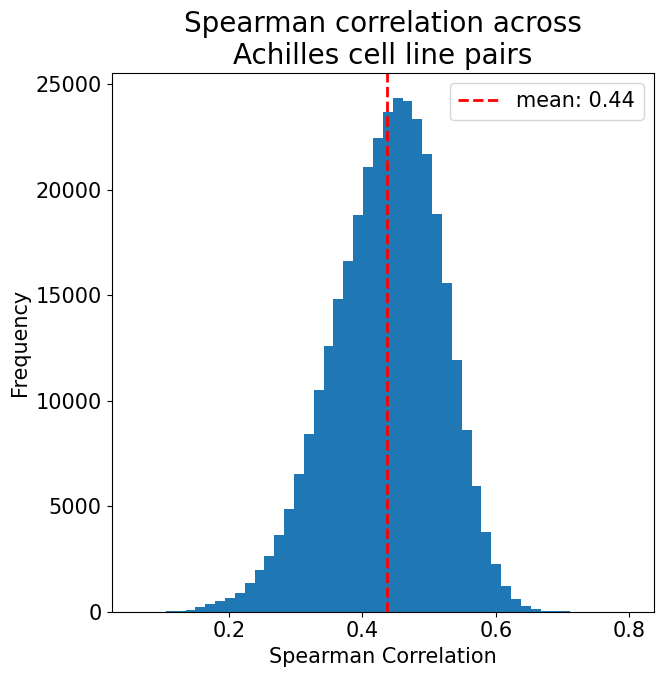

In [92]:
fig, ax = plt.subplots(1, figsize = (7,7))

ax.hist(spearman_corrs, bins = 50)
ax.axvline(
    np.mean(spearman_corrs), 
    linestyle = '--', 
    linewidth = 2, 
    color = 'red',
    label = f'mean: {np.mean(spearman_corrs):.2f}'
    )
ax.tick_params(labelsize = 15)
ax.set_xlabel("Spearman Correlation", size = 15)
ax.set_ylabel("Frequency", size = 15)
ax.set_title("Spearman correlation across\nAchilles cell line pairs", size = 20)
ax.legend(prop = {'size':15})

plt.show()

## Looking at overlap between tails

In [56]:
def truncate_k(x, k, geq = True):
    m, _ = x.shape
    rows, _ = np.indices((m, k))
    # get (unsorted) indices of top-k values
    if geq:
        k_indices = np.argpartition(x, -k, axis=1)[:, -k:]
        kth_vals = x[rows, k_indices].min(axis=1)
        is_kth = x >= kth_vals[:, None]
    else:
        k_indices = np.argpartition(x, k, axis=1)[:, :k]
        kth_vals = x[rows, k_indices].max(axis=1)
        is_kth = x <= kth_vals[:, None]

    return is_kth

In [75]:
binarized = np.full(filtered_df.transpose().values.shape, False)
binarized[truncate_k(filtered_df.transpose().values, 500, geq = True)] = True

In [76]:
#THRESH = 1.96
#binarized = zscore(filtered_df.transpose().values,axis = None) > THRESH

In [77]:
odds, p = vectorized_DEG_crosstab_distance(binarized, n=2, eps = 1e-6, alt ='greater')

In [78]:
ctabs = vectorized_make_crosstab(binarized, n=2)

In [79]:
import statsmodels as sm

for idx in np.arange(ctabs.shape[0]):
    for jdx in np.arange(idx+1, ctabs.shape[1]):
        tab = sm.stats.contingency_tables.Table(np.reshape(ctabs[:,idx,jdx],(2,2)))

        enrich = tab.table_orig/tab.fittedvalues
        if enrich[0,0]>50:
            break

In [80]:
tab.table_orig

array([[  113,   387],
       [  387, 15989]])

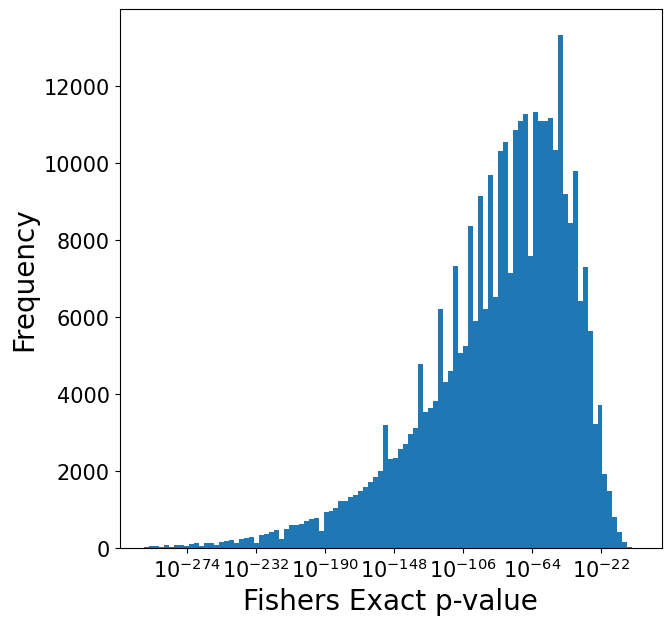

In [81]:
indices = np.triu_indices(ctabs[1].shape[0],1)
fig, ax = plt.subplots(1, figsize = (7,7))

ax.hist(p[indices], bins = np.logspace(-300,0,100))
ax.set_xscale('log')
ax.set_xlabel("Fishers Exact p-value", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.tick_params(labelsize = 15)

plt.show()

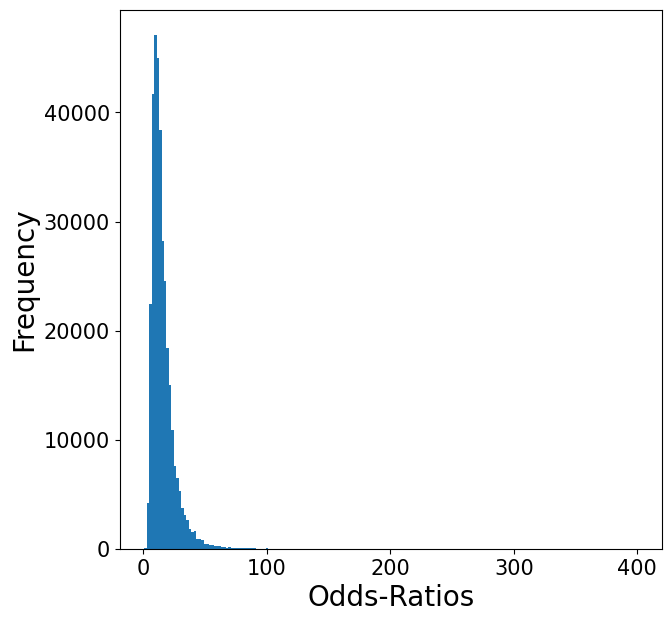

In [82]:
indices = np.triu_indices(ctabs[1].shape[0],1)
fig, ax = plt.subplots(1, figsize = (7,7))

ax.hist(odds[indices], bins = np.linspace(1,400,200))
ax.set_xlabel("Odds-Ratios", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.tick_params(labelsize = 15)
plt.show()

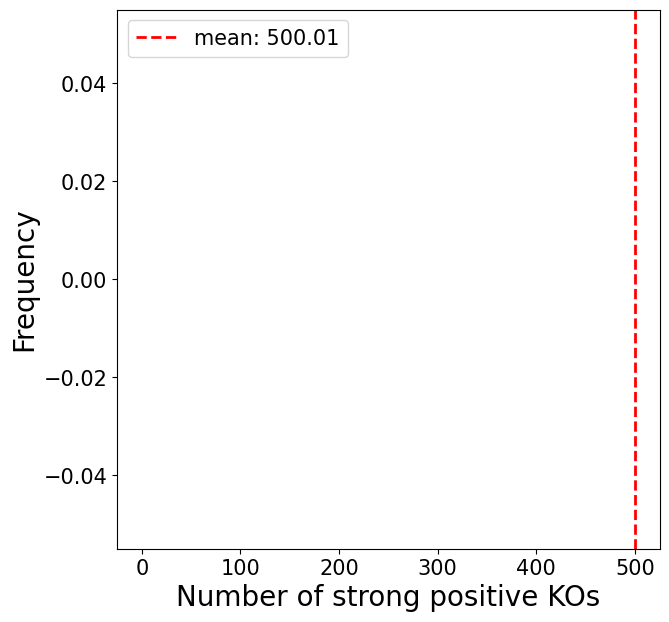

In [74]:
fig, ax = plt.subplots(1, figsize = (7,7))

ax.hist(binarized.sum(axis = 1), bins = np.linspace(0,400,400))
ax.axvline(
    np.mean(binarized.sum(axis = 1)), 
    linestyle = '--', 
    linewidth = 2, 
    color = 'red',
    label = f'mean: {np.mean(binarized.sum(axis = 1)):.2f}'
    )
ax.set_xlabel("Number of strong positive KOs", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.tick_params(labelsize = 15)
ax.legend(prop = {'size':15})
plt.show()